<a href="https://colab.research.google.com/github/kratiagrawal100/SMAI_Team_30/blob/main/ASL_Experiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pickle
import math

import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision import transforms
import torchvision
from PIL import Image
from matplotlib import pyplot as plt
import numpy as np

In [3]:
# !unzip "/content/drive/MyDrive/SMAI_Project/Sign-Language-Digits-Dataset-master.zip"
!unzip "/content/drive/MyDrive/SMAI_Project/Sign-Language-Digits-Dataset-master.zip"

Archive:  /content/drive/MyDrive/SMAI_Project/Sign-Language-Digits-Dataset-master.zip
4b09433ef9d5c60602e8805bb54b8aa2428527f8
replace Sign-Language-Digits-Dataset-master/Dataset/0/IMG_1118.JPG? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: Sign-Language-Digits-Dataset-master/Dataset/0/IMG_1118.JPG  
  inflating: Sign-Language-Digits-Dataset-master/Dataset/0/IMG_1128.JPG  
  inflating: Sign-Language-Digits-Dataset-master/Dataset/0/IMG_1138.JPG  
  inflating: Sign-Language-Digits-Dataset-master/Dataset/0/IMG_1148.JPG  
  inflating: Sign-Language-Digits-Dataset-master/Dataset/0/IMG_1158.JPG  
  inflating: Sign-Language-Digits-Dataset-master/Dataset/0/IMG_1169.JPG  
  inflating: Sign-Language-Digits-Dataset-master/Dataset/0/IMG_1179.JPG  
  inflating: Sign-Language-Digits-Dataset-master/Dataset/0/IMG_1189.JPG  
  inflating: Sign-Language-Digits-Dataset-master/Dataset/0/IMG_1199.JPG  
  inflating: Sign-Language-Digits-Dataset-master/Dataset/0/IMG_1209.JPG  
  inflating: Sign-Languag

In [4]:
import cv2
import os

def load_images_from_folder(abspath,folder):
    images = []
    labels=[]
    # print(os.path.join(abspath,folder))
    for filename in os.listdir(os.path.join(abspath,folder)):
        # print(os.path.join(abspath,folder,filename))
        img = cv2.imread(os.path.join(abspath,folder,filename))
        if img is not None:
            # print("here")
            # print(img.Resize(28,28))
            # img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            img=cv2.resize(img,(100,100))
            images.append(img)
            labels.append(int(folder))
    return images,labels
images = []
labels=[]
for i in range(10):
  img,lbls=load_images_from_folder("/content/Sign-Language-Digits-Dataset-master/Dataset",str(i))
  images.extend(img)
  labels.extend(lbls)

In [5]:
print(len(images),len(labels))

2062 2062


In [6]:
np.unique(labels)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

(100, 100, 3)


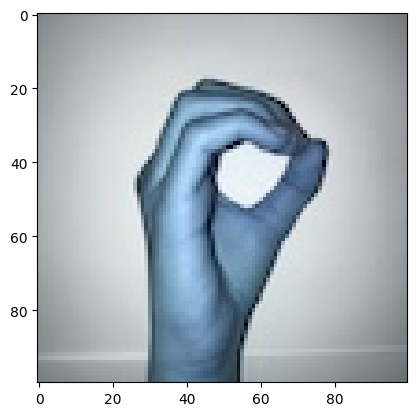

In [7]:
import matplotlib.pyplot as plt
print(images[200].shape)
plt.imshow(images[0])

In [21]:
import pickle as pkl
import tarfile
import tarfile
from urllib.request import urlretrieve
import os


import numpy as np
import skimage
import skimage.io
import skimage.transform
import torchvision


def _compose_image(digit, background):
    """Difference-blend a digit and a random patch from a background image."""
    w, h, _ = background.shape
    dw, dh, _ = digit.shape
    # print(w,dw)
    x = np.random.randint(0, w - dw)
    y = np.random.randint(0, h - dh)

    bg = background[x:x+dw, y:y+dh]
    return np.abs(digit-bg).astype(np.uint8)


def _mnist_to_img(x):
    """Binarize MNIST digit and convert to RGB."""
    # x = (x > 0).astype(np.float32)
    # d = x.reshape([100, 100,1 ]) * 255
    # return np.concatenate([d, d, d], 2)
    return x


def _create_mnistm(X, rand, background_data):
    """
    Give an array of MNIST digits, blend random background patches to
    build the MNIST-M dataset as described in
    http://jmlr.org/papers/volume17/15-239/15-239.pdf
    """
    X_ = np.zeros([X.shape[0], 100, 100, 3], np.uint8)
    for i in range(X.shape[0]):

        if i % 10000 == 0:
            print('Processing example', i)

        bg_img = rand.choice(background_data)

        d = _mnist_to_img(X[i])
        d = _compose_image(d, bg_img)
        X_[i] = d

    return X_


def create_mnistm():
  if os.path.exists('ASL_data.pkl'):
    return

  if not os.path.exists("BSR_bsds500.tgz"):
    urlretrieve("http://www.eecs.berkeley.edu/Research/Projects/CS/vision/grouping/BSR/BSR_bsds500.tgz", "BSR_bsds500.tgz")
  print('Creating MNIST-M... That may takes a minute')
  BST_PATH = 'BSR_bsds500.tgz'

  rand = np.random.RandomState(42)

  f = tarfile.open(BST_PATH)
  train_files = []
  for name in f.getnames():
      if name.startswith('BSR/BSDS500/data/images/train/'):
          train_files.append(name)

  print('Loading BSR training images')
  background_data = []
  for name in train_files:
      try:
          fp = f.extractfile(name)
          bg_img = skimage.io.imread(fp)
          background_data.append(bg_img)
      except:
          continue

  # mnist_train = torchvision.datasets.MNIST('.', train=True, download=True)
  # mnist_test = torchvision.datasets.MNIST('.', train=False, download=True)

  print('Building train set...')
  train = _create_mnistm(np.array(images), rand, background_data)
  print('Building test set...')
  test = _create_mnistm(np.array(images), rand, background_data)

  # Save dataset as pickle
  with open('ASL.pkl', 'wb+') as f:
      pkl.dump({ 'x_train': train, 'x_test': test, "y_train": np.array(labels), "y_test":np.array(labels)}, f, pkl.HIGHEST_PROTOCOL)

  print("Done!")


In [22]:
create_mnistm()

Creating MNIST-M... That may takes a minute
Loading BSR training images
Building train set...
Processing example 0


<ipython-input-21-d428c6e850b5>:47: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  bg_img = rand.choice(background_data)


Building test set...
Processing example 0
Done!


In [23]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(images,labels, test_size=0.25, random_state=42)

In [68]:
import torch
# svhn_pixels = torchvision.datasets.SVHN(root='./data', split='train', transform=transform, download=True).data/255
mean2 = 0.5
std2 = 0.5
# print(f"Mean {mean2} and Std {std2}")
mean2 = torch.tensor([mean2, mean2, mean2])
std2 = torch.tensor([std2, std2, std2])
transform = transforms.Compose([
    # transforms.Resize((28, 28)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean2, std=std2)
])
class ASL(torch.utils.data.Dataset):
  def __init__(self, x, y):
    self.x, self.y = x, y
    self.transform = transform


  def __len__(self):
    return len(self.x)

  def __getitem__(self, index):
    x, y = self.x[index], self.y[index]
    x = self.transform(x)

    return x, y
asl_train = ASL(images,labels)
asl_train,asl_test=torch.utils.data.random_split(asl_train, [1562, 500])
# asl_train, asl_test, y_train, y_test = train_test_split(images,labels, test_size=0.25, random_state=42)

source_train_loader = DataLoader(asl_train, batch_size=32)
source_test_loader = DataLoader(asl_test, batch_size=32)

In [69]:
with open('ASL.pkl', 'rb') as f:
  asl_m = pickle.load(f)
class ASLM(torch.utils.data.Dataset):
  def __init__(self, x, y):
    self.x, self.y = x, y
    self.transform = transform

  def __len__(self):
    return len(self.x)

  def __getitem__(self, index):
    x, y = self.x[index], self.y[index]
    x = self.transform(x)

    return x, y

aslm_train = ASLM(asl_m["x_train"],asl_m["y_train"])
aslm_train,aslm_test=torch.utils.data.random_split(aslm_train, [1562, 500])

target_train_loader = DataLoader(aslm_train, batch_size=32)
target_test_loader = DataLoader(aslm_test, batch_size=32)

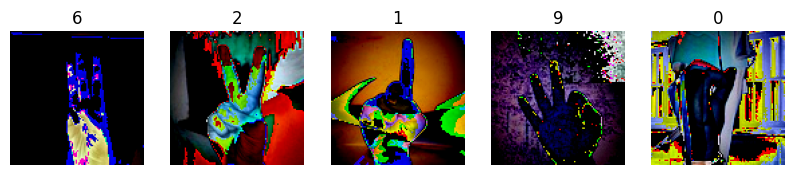

In [70]:
plt.figure(figsize=(10, 7))

for i in range(5):
  ax = plt.subplot(1, 5, i + 1)
  ax.axis('off')

  x, y = aslm_train[i]
  img = (x.permute(1,2,0))
  plt.imshow(img)
  # plt.imshow(images[i])
  plt.title(y)

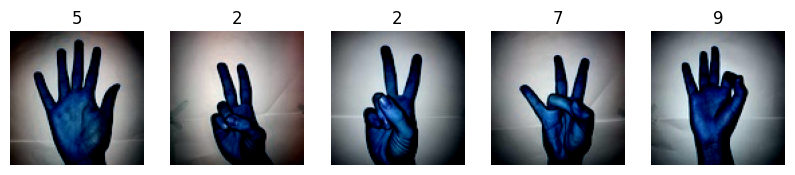

In [71]:
plt.figure(figsize=(10, 7))

for i in range(5):
  ax = plt.subplot(1, 5, i + 1)
  ax.axis('off')

  x, y = asl_train[i]
  img = (x.permute(1,2,0))
  plt.imshow(img)
  # plt.imshow(images[i])
  plt.title(y)

In [72]:
class NaiveNet(nn.Module):
  def __init__(self):
    super().__init__()  # Important, otherwise will throw an error

    #100,100,3
    self.cnn = nn.Sequential(
        nn.Conv2d(3, 64, kernel_size=5),  # 96*96*32
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2,stride=2),  # 48*48*64
        nn.Conv2d(64, 64, kernel_size=5),  # 44*44*64
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2),  #22*22*64
        nn.Conv2d(64, 128, kernel_size=5) # 18*18*128
    )

    self.classif = nn.Sequential(
        nn.Linear(18 * 18 * 128, 100),
        nn.ReLU(inplace=True),
        nn.Linear(100, 100),
        nn.ReLU(inplace=True),
        nn.Linear(100, 10)
    )

  def forward(self, x):
    batch_size = len(x)
    # print(x.shape)
    # print(batch_size)

    x = self.cnn(x)
    # print(x)
    x = x.view(batch_size, -1)
    # print(x)
    return self.classif(x)


# NaiveNet()(torch.randn(2, 3, 28, 28)).shape

In [73]:
def eval_model(net, loader):
  net.eval()

  acc, loss = 0, 0.
  c = 0
  for x, y in loader:
    c += len(x)

    with torch.no_grad():
      logits = net(x.cuda()).cpu()

    loss += F.cross_entropy(logits, y).item()
    acc += (logits.argmax(dim=1) == y).sum().item()

  return round(100 * acc / c, 2), round(loss / len(loader), 5)

In [74]:
epochs = 10

naive_net = NaiveNet().cuda()

optimizer = torch.optim.SGD(naive_net.parameters(), lr=0.01, momentum=0.9)

# mu0, alpha, beta = 0.01, 10, 0.75
# scheduler = torch.optim.lr_scheduler.LambdaLR(
#     optimizer,
#     lambda e: mu0 / (1 + alpha * e / epochs) ** beta
# )

for epoch in range(epochs):
  train_loss = 0.

  for x, y in source_train_loader:
    # print(x.permute(0,3,1,2).shape)
    x, y = x.cuda(),y.cuda()
    naive_net.zero_grad()
    optimizer.zero_grad()
    logits = naive_net(x)
    # print(logits)
    loss = F.cross_entropy(logits, y)
    loss.backward()
    optimizer.step()

    train_loss += loss.item()
  print(f'Epoch {epoch}, train loss: {round(train_loss / len(source_train_loader), 5)}')
  # scheduler.step()
  print(f"\tLearning rate = {optimizer.param_groups[0]['lr']}")

test_acc, test_loss = eval_model(naive_net, source_test_loader)
print(f"Test loss: {test_loss}, test acc: {test_acc}")

Epoch 0, train loss: 2.28694
	Learning rate = 0.01
Epoch 1, train loss: 1.33254
	Learning rate = 0.01
Epoch 2, train loss: 0.65422
	Learning rate = 0.01
Epoch 3, train loss: 0.4318
	Learning rate = 0.01
Epoch 4, train loss: 0.27816
	Learning rate = 0.01
Epoch 5, train loss: 0.20947
	Learning rate = 0.01
Epoch 6, train loss: 0.20298
	Learning rate = 0.01
Epoch 7, train loss: 0.1189
	Learning rate = 0.01
Epoch 8, train loss: 0.10344
	Learning rate = 0.01
Epoch 9, train loss: 0.05324
	Learning rate = 0.01
Test loss: 0.21113, test acc: 94.2


In [75]:
test_acc, test_loss = eval_model(naive_net, target_test_loader)
print(f"Test loss: {test_loss}, test acc: {test_acc}")

Test loss: 9.06757, test acc: 24.4


In [76]:
class GradientReversal(torch.autograd.Function):
  @staticmethod
  def forward(ctx, x, factor=-1):
    ctx.save_for_backward(torch.tensor(factor))
    return x

  @staticmethod
  def backward(ctx, grad):
    factor, = ctx.saved_tensors

    return factor * grad, None


In [77]:
class DANN(nn.Module):
  def __init__(self):
    super().__init__()  # Important, otherwise will throw an error
    self.cnn = nn.Sequential(
          nn.Conv2d(3, 64, kernel_size=5),  # 96*96*32
          nn.ReLU(inplace=True),
          nn.MaxPool2d(kernel_size=2,stride=2),  # 48*48*64
          nn.Conv2d(64, 64, kernel_size=5),  # 44*44*64
          nn.ReLU(inplace=True),
          nn.MaxPool2d(kernel_size=2, stride=2),  #22*22*64
          nn.Conv2d(64, 128, kernel_size=5) # 18*18*128
      )

    self.classif = nn.Sequential(
          nn.Linear(18 * 18 * 128, 100),
          nn.ReLU(inplace=True),
          nn.Linear(100, 100),
          nn.ReLU(inplace=True),
          nn.Linear(100, 10)
      )


    self.domain = nn.Sequential(
          nn.Linear(18*18*128, 1024),
          nn.ReLU(inplace=True),
          nn.Linear(1024, 1024),
          nn.ReLU(inplace=True),
          nn.Linear(1024, 1)
      )

    self.grl = GradientReversal.apply

  def forward(self, x, factor=1):
    batch_size = len(x)

    x = self.cnn(x)
    x = x.view(batch_size, -1)

    class_pred = self.classif(x)
    domain_pred = self.domain(self.grl(x, -1 * factor))

    return class_pred, domain_pred


In [78]:
def eval_dann(net, loader, source=True):
  net.eval()

  c_acc, d_acc, cls_loss, d_loss = 0, 0, 0., 0.
  c = 0
  for x, y in loader:
    x = x.cuda()
    if source:
      d = torch.ones(len(x))
    else:
      d = torch.zeros(len(x))

    c += len(x)

    with torch.no_grad():
      cls_logits, domain_logits = net(x.cuda())
      cls_logits, domain_logits = cls_logits.cpu(), domain_logits.cpu()

    cls_loss += F.cross_entropy(cls_logits, y).item()
    d_loss += F.binary_cross_entropy_with_logits(domain_logits[:, 0], d).item()

    c_acc += (cls_logits.argmax(dim=1) == y).sum().item()
    d_acc += ((domain_logits[:, 0] > 0.5).float() == d).sum().item()

  return round(100 * c_acc / c, 2), round(100 * d_acc / c, 2), round(cls_loss / len(loader), 5), round(d_loss / len(loader), 5)

In [81]:
epochs = 10

dann = DANN().cuda()

optimizer = torch.optim.SGD(dann.parameters(), lr=0.001, momentum=0.9)

# mu0, alpha, beta = 0.01, 10, 0.75
# scheduler = torch.optim.lr_scheduler.LambdaLR(
#     optimizer,
#     lambda e: 0.01 / (1 + alpha * e / epochs) ** beta
# )
lmbd = lambda e: -1 + 2 / (1 + math.exp(-2 * e / (len(source_train_loader) * epochs)))

b = 0
for epoch in range(epochs):
  cls_loss, domain_loss = 0., 0.
  grl_factor = lmbd(b)
  # grl_factor = 10
  print(f"GRL factor {grl_factor}" )

  for (xs, ys), (xt, _) in zip(source_train_loader, target_train_loader):
    grl_factor = lmbd(b)
    # grl_factor = 10
    b += 1

    xs, ys = xs.cuda(), ys.cuda()
    xt = xt.cuda()
    x = torch.cat((xs, xt))

    optimizer.zero_grad()
    cls_logits, domain_logits = dann(x, factor=grl_factor)

    ce = F.cross_entropy(cls_logits[:len(ys)], ys)

    bce = F.binary_cross_entropy_with_logits(
        domain_logits[:, 0],
        torch.cat((
            torch.ones(len(xs)),
            torch.zeros(len(xt))
        )).cuda()
    )
    loss = ce + bce
    loss.backward()
    optimizer.step()

    cls_loss += (ce.item())
    domain_loss += (bce.item())

  # cls_loss = round(cls_loss / len(source_train_loader), 7)
  # domain_loss = round(domain_loss / len(source_train_loader),7 )
  
  cls_loss = round(cls_loss, 7)
  domain_loss = round(domain_loss,7 )
  print(f'Epoch {epoch}, class loss: {cls_loss}, domain loss: {domain_loss}')
  # scheduler.step()

c_acc, d_acc, c_loss, d_loss = eval_dann(dann, source_test_loader)
print(f"[SOURCE] Class loss/acc: {c_loss} / {c_acc}%, Domain loss/acc: {d_loss} / {d_acc}%")

c_acc, d_acc, c_loss, d_loss = eval_dann(dann, target_test_loader, source=False)
print(f"[TARGET] Class loss/acc: {c_loss} / {c_acc}%, Domain loss/acc: {d_loss} / {d_acc}%")

GRL factor 0.0
Epoch 0, class loss: 112.7802093, domain loss: 32.7217097
GRL factor 0.0996679946249559
Epoch 1, class loss: 112.5022764, domain loss: 29.2110861
GRL factor 0.197375320224904
Epoch 2, class loss: 112.419364, domain loss: 33.0196942
GRL factor 0.2913126124515908
Epoch 3, class loss: 112.262476, domain loss: 30.3069084
GRL factor 0.379948962255225
Epoch 4, class loss: 111.8610442, domain loss: 31.1453167
GRL factor 0.4621171572600098
Epoch 5, class loss: 111.4408615, domain loss: 31.7313333
GRL factor 0.5370495669980351
Epoch 6, class loss: 111.5531034, domain loss: 30.8277139
GRL factor 0.6043677771171634
Epoch 7, class loss: 110.5675123, domain loss: 31.9764072
GRL factor 0.6640367702678489
Epoch 8, class loss: 104.7288033, domain loss: 23.0156987
GRL factor 0.7162978701990246
Epoch 9, class loss: 103.8996636, domain loss: 20.814993
[SOURCE] Class loss/acc: 2.09108 / 22.0%, Domain loss/acc: 0.22696 / 91.6%
[TARGET] Class loss/acc: 3.9957 / 18.4%, Domain loss/acc: 0.82175

In [82]:
test_acc, test_loss,a,b= eval_dann(dann, target_test_loader)
print(f"Test loss: {test_loss}, test acc: {test_acc},a:{a},b:{b}")

Test loss: 29.8, test acc: 18.4,a:3.9957,b:1.66141
